In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import torch
from torch import nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule
from pyro.infer import SVI, Trace_ELBO
import os
from functools import partial

In [4]:
data_folder = './BeerAdvocate/'

In [256]:
df_beers = pd.read_pickle(data_folder + 'beers.pkl')
df_breweries = pd.read_pickle(data_folder + 'breweries.pkl')
df_users = pd.read_pickle(data_folder + 'users.pkl')
df = pd.read_pickle(data_folder + 'ratings.pkl')

## Descriptive analysis of beer styles 

### Analysis of beer styles main production and rating countries

In [258]:
# We merge the ratings with the beer dataset to get the style for each beer and the brewery id
df_merged = df.merge(df_beers[['beer_id','brewery_id','style','abv']], left_on='beer_id', right_on='beer_id')

In [259]:
df_merged.head()

,beer_id,date,user_id,appearance,aroma,palate,taste,overall,rating,review,brewery_id,style,abv
0,142544,2015-08-20 10:00:00,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,True,37262,Euro Pale Lager,4.5
1,19590,2009-02-20 11:00:00,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,True,10093,English Pale Ale,4.5
2,19590,2006-03-13 11:00:00,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,True,10093,English Pale Ale,4.5
3,19590,2004-12-01 11:00:00,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,True,10093,English Pale Ale,4.5
4,19590,2004-08-30 10:00:00,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,True,10093,English Pale Ale,4.5


In [260]:
# merge the df_ba dataset with the df_breweries dataset to get the location where the beers are brewed
df_merged = df_merged.merge(df_breweries[['id','location']], left_on='brewery_id', right_on='id')

# convert dates to datetime
df_merged["date"] = df_merged["date"].apply(pd.to_datetime,unit='s')

# creates column with corresponding country where  beer is brewed
countries = ["United States","Canada","Utah","England","Wales","Scotland"]
df_merged["country"] = df_merged["location"]
for country in countries:
    df_merged["bool"] = df_merged["location"].apply(lambda x: country in x)
    if country == "Utah":
        country = "United States"
    df_merged.loc[df_merged["bool"],"country"] = country
    del df_merged['bool']
    
df_merged.head()

,beer_id,date,user_id,appearance,aroma,palate,taste,overall,rating,review,brewery_id,style,abv,id,location,country
0,142544,2015-08-20 10:00:00,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,True,37262,Euro Pale Lager,4.5,37262,Gabon,Gabon
1,19590,2009-02-20 11:00:00,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,True,10093,English Pale Ale,4.5,10093,Northern Ireland,Northern Ireland
2,19590,2006-03-13 11:00:00,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,True,10093,English Pale Ale,4.5,10093,Northern Ireland,Northern Ireland
3,19590,2004-12-01 11:00:00,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,True,10093,English Pale Ale,4.5,10093,Northern Ireland,Northern Ireland
4,19590,2004-08-30 10:00:00,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,True,10093,English Pale Ale,4.5,10093,Northern Ireland,Northern Ireland


In [261]:
# creates column with corresponding user country
df_users["user_country"] = df_users["location"]
for country in countries:
    df_users["bool"] = df_users[df_users["location"].notnull()]["location"].apply(lambda x: country in x)
    if country == "Utah":
        country = "United States"
    df_users.loc[df_users["bool"] == True,"user_country"] = country
    del df_users['bool']

In [262]:
df_users.columns = ["user_nbr_ratings", "user_nbr_reviews", "user_id", "user_name", "date_joined", "location", "user_country"]

In [442]:
# merge ratings with user dataset to get user country and number of ratings 
df = df_merged[["user_id", "date", "aroma", "palate", "taste", "overall", "rating","abv", "style", "country","beer_id"]].merge(df_users[['user_nbr_ratings','user_nbr_reviews','user_id','user_country']], left_on='user_id', right_on='user_id')

In [443]:
df.head()

,user_id,date,aroma,palate,taste,overall,rating,abv,style,country,beer_id,user_nbr_ratings,user_nbr_reviews,user_country
0,nmann08.184925,2015-08-20 10:00:00,2.75,3.25,2.75,3.00,2.88,4.5,Euro Pale Lager,Gabon,142544,7820,465,United States
1,nmann08.184925,2015-11-14 11:00:00,3.50,3.75,3.50,3.50,3.56,5.0,Extra Special / Strong Bitter (ESB),Wales,120824,7820,465,United States
2,nmann08.184925,2011-11-18 11:00:00,NaN,NaN,NaN,NaN,4.50,8.0,Old Ale,Scotland,47581,7820,465,United States
3,nmann08.184925,2013-05-03 10:00:00,NaN,NaN,NaN,NaN,3.75,10.5,Old Ale,Scotland,93113,7820,465,United States
4,nmann08.184925,2015-01-24 11:00:00,3.50,3.75,4.00,3.75,3.81,6.0,English Porter,Scotland,875,7820,465,United States


In [444]:
types_features = []
types_features.append(["amber ale", "american pale ale", "english pale ale", "blonde ale", "bitter"])     #Pale Ales
types_features.append(["amber lager", "dunkel", "marzen", "oktoberfest", "schwarzbier", "vienna lager", "dark lager", "red lager"])    #Dark Lagers
types_features.append(["brown ale", "mild"])     #Brown Ales
types_features.append(["ipa", "indian pale ale"])     #India Pale Ales
types_features.append(["wheat wine ale", "wheat", "witbier", "weisse", "weissbier", "dunkelweizen", "hefeweizen", "kristalweizen"])     #Wheat Beers
types_features.append(["barley wine", "barleywine",  "imperial red ale", "barley wine ale", "old ale", "strong ale", "strong pale ale"])     #Strong Ales
types_features.append(["belgian blonde ale", "dubbel", "belgian strong dark ale", "belgian dark ale", "golden strong ale", "belgian pale ale", "quadrupel", "saison", "tripel"])     #Belgian Styles
types_features.append(["cream ale", "biere de garde", "bière de garde", "common", "altbier", "kolsch", "kölsch", "red beer", "red ale"])     #Hybrid Beers
types_features.append(["porter"])     #Porters
types_features.append(["stout"])     #Stouts
types_features.append(["bock", "doppelbock", "maibock", "weizenbock"])     #Bocks
types_features.append(["heavy", "scottish ale"])     #Scottish-Style Ales
types_features.append(["brett", "sour", "flanders", "lambic", "faro", "gueuze", "gose", "wild"])     #Wild/Sour Beers
types_features.append(["pale lager", "american Lager", "american adjunct lager", "pilsener", "pilsner", "export", "helles"])     #Pilseners and Pale Lagers
types_features.append(["black ale", "barrel-aged", "chocolate", "coffee", "fruit", "field", "craft", "herb", "spice", "honey", "pumpkin", "rye", "roggenbier", "session", "smoke", "rauchbier", "specialty", "sahti"])     #Specialty Beers

In [445]:
types = {}
i = 1
for type_features in types_features:
    for key in type_features:
        types[key] = i
    i += 1

In [446]:
# add the merged styles to the 
df["style_merged"] = 15
for type, label in types.items():
    df["bool"] = df["style"].apply(lambda x: type in x.lower())
    df.loc[df["bool"], "style_merged"] = label
    del df['bool']
df['style_merged'] = df['style_merged'].astype("string")
df.head()

,user_id,date,aroma,palate,taste,overall,rating,abv,style,country,beer_id,user_nbr_ratings,user_nbr_reviews,user_country,style_merged
0,nmann08.184925,2015-08-20 10:00:00,2.75,3.25,2.75,3.00,2.88,4.5,Euro Pale Lager,Gabon,142544,7820,465,United States,14
1,nmann08.184925,2015-11-14 11:00:00,3.50,3.75,3.50,3.50,3.56,5.0,Extra Special / Strong Bitter (ESB),Wales,120824,7820,465,United States,1
2,nmann08.184925,2011-11-18 11:00:00,NaN,NaN,NaN,NaN,4.50,8.0,Old Ale,Scotland,47581,7820,465,United States,6
3,nmann08.184925,2013-05-03 10:00:00,NaN,NaN,NaN,NaN,3.75,10.5,Old Ale,Scotland,93113,7820,465,United States,6
4,nmann08.184925,2015-01-24 11:00:00,3.50,3.75,4.00,3.75,3.81,6.0,English Porter,Scotland,875,7820,465,United States,9


In the following, we create a dataframe that summarizes for each beer style its abv range, the main production country and main rating country.

In [283]:
# create dataframe to analyse the production countries, rating countries and abv ranges of each beer style 
df_styles = pd.DataFrame(columns=['style','main_substyle','number of substyles', 'main_production_country', 'nbr_production_countries', 'main_rating_country', 'nbr_rating_countries', 'avg_ratings', 'abv_range'])
for style, group in df.groupby(["style_merged"]):
    by_country = {
        'style': [style],
        'main_substyle': [group["style"].value_counts().keys()[group["style"].value_counts().argmax()]],
        'number of substyles': [len(group["style"].unique())],
        'main_production_country': [group["country"].value_counts().keys()[group["country"].value_counts().argmax()]],
        'nbr_production_countries': [len(group["country"].unique())],
        'main_rating_country': [group["user_country"].value_counts().keys()[group["user_country"].value_counts().argmax()]],
        'nbr_rating_countries': [len(group["user_country"].unique())],
        'avg_ratings': [np.nanmean(group["rating"])],
        'abv_range': [[group["abv"].min(), group["abv"].max()]]
    }
    df_styles = pd.concat([df_styles, pd.DataFrame(by_country)], axis=0)

df_styles.reset_index(drop=True, inplace=True)

In [287]:
df_styles

,style,main_substyle,number of substyles,main_production_country,nbr_production_countries,main_rating_country,nbr_rating_countries,avg_ratings,abv_range
0,1,American Pale Ale (APA),5,United States,97,United States,111,3.756001,"[1.4, 14.1]"
1,10,American Double / Imperial Stout,7,United States,88,United States,113,4.127981,"[1.0, 40.0]"
2,11,Doppelbock,4,United States,58,United States,90,3.850055,"[3.4, 65.0]"
3,12,Scotch Ale / Wee Heavy,2,United States,43,United States,81,3.902776,"[2.7, 20.2]"
4,13,American Wild Ale,7,United States,42,United States,85,4.128377,"[1.3, 25.0]"
5,14,American Adjunct Lager,10,United States,176,United States,120,3.337627,"[0.5, 17.0]"
6,15,Fruit / Vegetable Beer,24,United States,125,United States,114,3.576524,"[0.01, 28.0]"
7,2,Märzen / Oktoberfest,6,United States,104,United States,102,3.583071,"[2.0, 11.9]"
8,3,American Brown Ale,4,United States,65,United States,92,3.773366,"[2.0, 15.0]"
9,4,American IPA,4,United States,83,United States,120,4.024632,"[0.5, 41.0]"


We notice that the beer styles are all rated and produced mostly in the United States. This might be due to the fact that most users in our dataset are from the United-States and are more likely to rate beers from their own country. 

The best rated supra-style on average is the wild/sour ales style. 

To get an idea on how the production and ratings are distributed for a specific style, we plot the histograms.

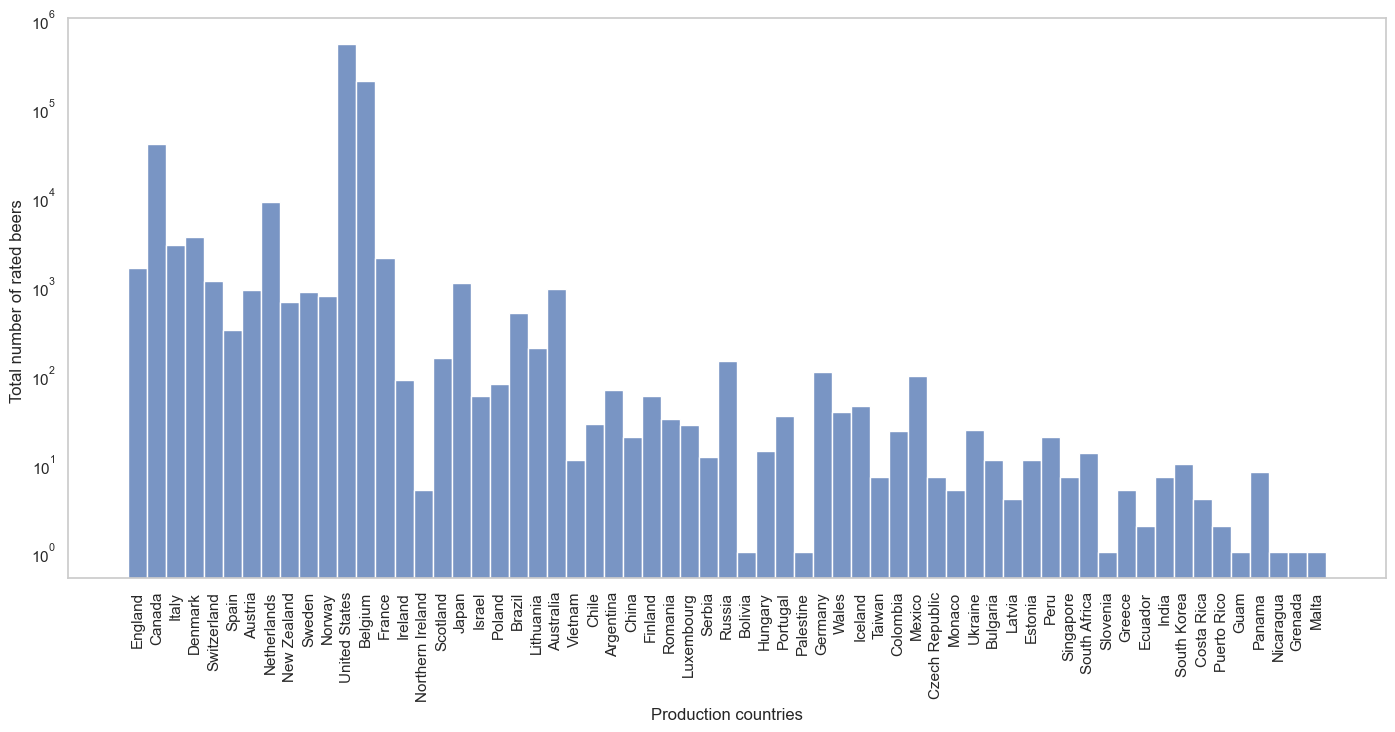

In [600]:
#define Seaborn color palette to use
sns.set(font_scale=1)
sns.set_style("whitegrid")
colors = sns.color_palette("colorblind", 16)

fig, ax = plt.subplots(figsize=(17, 7.27))
sns.histplot(df[df["style_merged"]=="7"].country, ax=ax, bins=len(df[df["style_merged"]=="7"].country.unique()))
ax.set_yscale('log')
ax.set_xlabel('Production countries')
ax.set_ylabel('Total number of rated beers ')
ax.grid(False)
plt.xticks(rotation=90)
plt.show()

In our dataset, the 3 countries that produce the most Belgian styles are the United States, Belgium and Canada. 

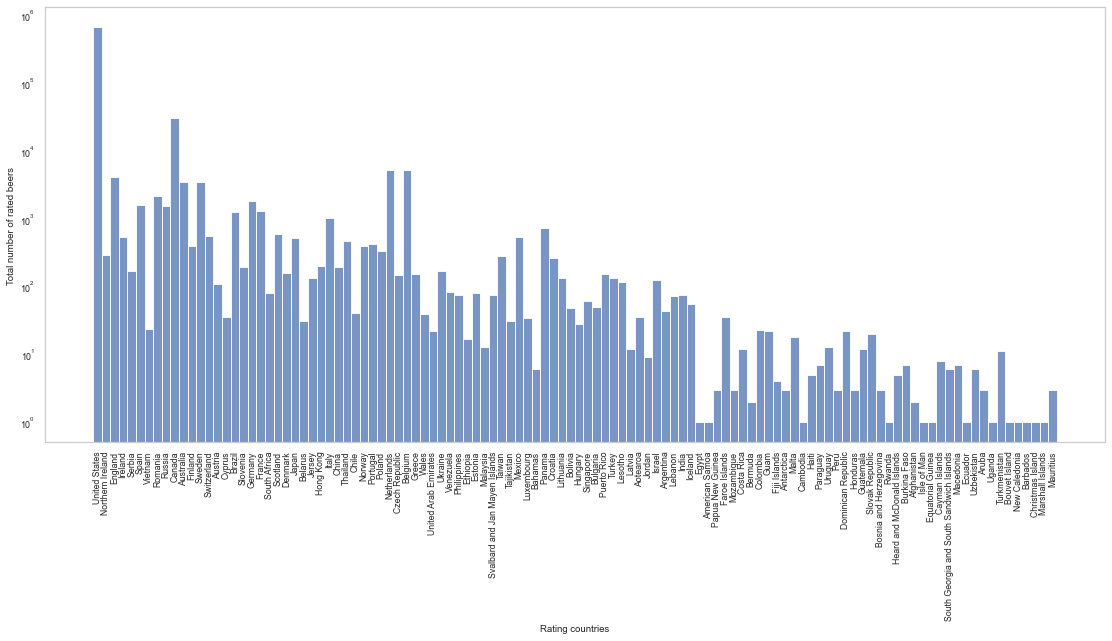

In [311]:
sns.set(font_scale=0.8)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(19, 8))
sns.histplot(df[df["style_merged"]=="7"].user_country, ax=ax, bins=len(df[df["style_merged"]=="7"].user_country.unique()))
ax.set_yscale('log')
ax.set_xlabel('Rating countries')
ax.set_ylabel('Total number of rated beers ')
ax.grid(False)
plt.xticks(rotation=90)
plt.show()

In our dataset, the 3 countries that rate the most Belgian styles are the United States, Belgium and Canada. 

#### Visualization of the ratings depending on the style

We can also visualize the mean ratings of each supra-style to see if they differ in terms of ratings.

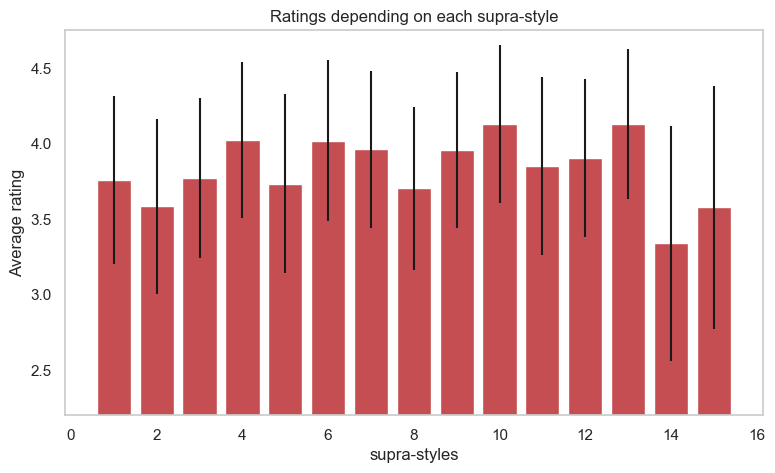

In [714]:
# plot the ratings depending on the style
fig, ax = plt.subplots(figsize=(9, 5))
df["style_merged"] = df["style_merged"].astype(int)
ax.bar(df.groupby("style_merged")["rating"].mean().keys(),df.groupby("style_merged")["rating"].mean().values,yerr=df.groupby("style_merged")["rating"].std().values,color="r")
ax.set_xlabel('supra-styles')
ax.set_ylabel('Average rating')
ax.grid(False)
ax.set_title("Ratings depending on each supra-style")
plt.ylim([2.2,4.75])
plt.show()

As we can see, the beer style with the highest ratings is the stout style and the one with the lowest ratings is pilsener and pale lager style. 

## Categorization of the users justificative analysis

#### Regression analysis

We have decided to categorize the users based on their country and their experience (based on the number of ratings). The following anaylsis intends to justify these choices by showing that the level of experience of a user and his country of origin influence his preferences in beer styles.  

First of all, to get an idea of the user preferences depending on the country of origin and the experience for a user we will conduct a regression analysis predicting the favorite style of a user based on his country of origin and his number of  previous ratings. 

In [59]:
# create dictionary with beers rated for each user
df_grouped_by_user = df.groupby("user_id")
users_dict = {}
for key,group in df.groupby("user_id"):
    users_dict[key] = pd.DataFrame(columns=['aroma','palate','taste','overall','rating','style','country','user_nbr_ratings','user_nbr_reviews','user_country','style_merged'])
    users_dict[key] = group

In [60]:
# summerize the dictionary into a new dataframe 
df_summary = pd.DataFrame(columns=['user','total_ba_ratings','country', 'main_country_rated', 'nbr_countries_rated', 'fav_country', 'main_style_rated', 'nbr_styles_rated','fav_style','fav_merged_style','total_ratings'])
for key in users_dict:
    by_user = {
        'user': [key],
        'country': [users_dict[key]["user_country"].iloc[0]],
        'main_country_rated':[users_dict[key]["country"].value_counts().keys()[
            users_dict[key]["country"].value_counts().argmax()]],
        'nbr_countries_rated':[users_dict[key]["country"].nunique()],
        'fav_country':[users_dict[key].sort_values(by="rating",ascending=False)["country"][:3].value_counts().keys()[
            users_dict[key].sort_values(by="rating",ascending=False)["country"][:3].value_counts().argmax()]],
        'main_style_rated': [users_dict[key]["style"].value_counts().keys()[
            users_dict[key]["style"].value_counts().argmax()]],
        'nbr_styles_rated': [users_dict[key]["style"].nunique()],
        'fav_style':[users_dict[key].sort_values(by="rating",ascending=False)["style"][:3].value_counts().keys()[
            users_dict[key].sort_values(by="rating",ascending=False)["style"][:3].value_counts().argmax()]],
        'fav_merged_style':[users_dict[key].sort_values(by="rating",ascending=False)["style_merged"][:3].value_counts().keys()[
            users_dict[key].sort_values(by="rating",ascending=False)["style_merged"][:3].value_counts().argmax()]],
        'total_ratings': [users_dict[key]["user_nbr_ratings"].iloc[0]],
    }
    df_summary = pd.concat([df_summary, pd.DataFrame(by_user)], axis=0)
    
df_summary.reset_index(drop=True, inplace=True)

In [67]:
df_summary["total_ratings"] = df_summary["total_ratings"].astype("int")
df_summary.head()

,user,total_ba_ratings,country,main_country_rated,nbr_countries_rated,fav_country,main_style_rated,nbr_styles_rated,fav_style,fav_merged_style,total_ratings
0,-----kiki-----.1000245,2,NaN,United States,1,United States,American Pale Lager,2,American Double / Imperial IPA,4,2
1,---.940711,3,NaN,United States,1,United States,American Pale Wheat Ale,3,American Pale Wheat Ale,4,3
2,--dida--.1042029,3,Canada,Canada,2,Canada,Cream Ale,3,American Double / Imperial IPA,4,3
3,--dom--.709199,165,United States,United States,8,United States,American Double / Imperial IPA,31,American Barleywine,6,165
4,--nomad--.931404,1,United States,United States,1,United States,American IPA,1,American IPA,4,1


In [68]:
one_hot_df = pd.get_dummies(df_summary[["country","fav_merged_style","total_ratings"]])

In [96]:
new_col = pd.DataFrame(np.array(one_hot_df.columns))
new_col[0] = new_col[0].astype("string").apply(lambda x: x.replace(" ", "_"))
one_hot_df.columns = new_col[0].values

Now we can compute a regression that predicts the probability that a given style will be a user favorite depending on the country and the number of ratings of a user. 

For example, we can compute the likelyhood on a scale of 0 to 1 that IPA's are the favorite style for a user coming either from the United states, depending on his number of ratings. 

In [596]:
mod = smf.ols(formula='fav_merged_style_4 ~ total_ratings + country_United_States',data=one_hot_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     fav_merged_style_4   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     171.7
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           3.18e-75
Time:                        17:22:22   Log-Likelihood:                -99478.
No. Observations:              153704   AIC:                         1.990e+05
Df Residuals:                  153701   BIC:                         1.990e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.28

In [597]:
res.params.values

array([ 2.82501288e-01, -5.13556524e-05,  4.19124358e-02])

The intercept is quite high, which indicates that IPA's are a popular style among american users. Moreover the coefficient multiplying the number of users is negative, which implies that the higher the  number of ratings of a user, the less likely his favorite style will be IPA's.

Now to compare the preferences for different beer styles among multiple countries we can plot these regressions for 4 different styles (IPA, Belgian-style ales, Stouts and Pilseners) and 4 countries (United States, Belgium, Canada and Germany) to compare: 

In [175]:
# compute regression for each country and each beer style
countries = ["country_United_States", "country_Belgium", "country_Canada", "country_Germany"]
styles = ["fav_merged_style_4", "fav_merged_style_7", "fav_merged_style_10","fav_merged_style_14"]
coefficients = []
for style in styles:
    coefficients_by_country = []
    for country in countries:
        regression_formula = style + ' ~ total_ratings + ' + country
        mod = smf.ols(formula=regression_formula,data=one_hot_df)
        res = mod.fit()
        coefficients_by_country.append(res.params.values)
    coefficients.append(coefficients_by_country)
    

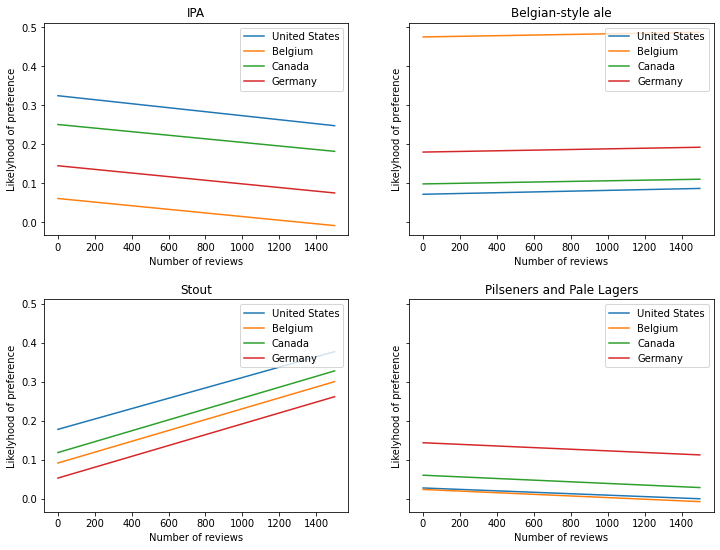

In [177]:
# plot the results
nb_ratings = np.arange(1, 1500)
fig, axes = plt.subplots(2, 2, figsize=(12, 9),sharey=True) 
plt.subplots_adjust(hspace=0.3)
countries = ["United States","Belgium","Canada","Germany"]
styles = ["IPA", "Belgian-style ale", "Stout", "Pilseners and Pale Lagers"]

for i in range(4):
    x,y = [0,0]
    if ((i+1) % 2) == 0: y = 1
    if (i>1): x = 1
    for j in range(4):
        axes[x,y].plot(nb_ratings,coefficients[i][j][0] + coefficients[i][j][1] * nb_ratings + coefficients[i][j][2],label=countries[j])

    axes[x,y].set_title(styles[i])
    axes[x,y].set_xlabel('Number of reviews')
    axes[x,y].set_ylabel('Likelyhood of preference')
    axes[x,y].legend(loc="upper right")
    
    

As we can see on the plots above, there is a clear difference of beer style preferences from one country to another. For example, a user from the United States will likely prefer IPA's or Stouts rather than Belgian-style ales. While a user from Belgium will likely prefer Belgian-style ales rather than IPA's. As it was seen before, these differences can be explained by the fact that a user is most likely to rate beers from his own country, thus he will also likely prefer beers produced in his country. In fact, the U-S produce a lot of IPA's and Belgium produces many belgian-style ales. 

#### Statistical analysis on user experience 

Another way to prove that user experience has an influence on the beer styles preferences would be to choose a set of "experienced" users and see how their preferences vary in time. In the following analysis we will compare the user preferences among the 50 first ratings of each user with the user preferences among the 50 last ratings for users having done more than 500 ratings in total. 

We will compare the user preferences by conducting a type of paired statistical test called the The Wilcoxon signed-rank test. It tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test test, since our two populations are dependant.

In [196]:
# create a dictionary with only experienced users 
experienced_users_dict = {}
for key,group in df.loc[df["user_nbr_ratings"]>500].groupby("user_id"):
    experienced_users_dict[key] = pd.DataFrame(columns=['rating','date','style','country','user_nbr_ratings','user_nbr_reviews','user_country','style_merged'])
    group_sorted = group.sort_values(by="date")
    group_sorted["date"] = group_sorted["date"].apply(pd.to_datetime,unit='s')
    experienced_users_dict[key] = group_sorted[['rating','date','style','country','user_nbr_ratings','user_nbr_reviews','user_country','style_merged']]

In [316]:
# summerize the dictionary of experienced into a new dataframe by separating their style preferences when thaey first started rating beers and the most recent ratings they did 
experienced_users_summary = pd.DataFrame(columns=['user','country', 'main_country_rated_before', 'main_country_rated_after', 'fav_country_before', 'fav_country_after','main_style_rated_before','main_style_rated_after','fav_style_before','fav_merged_style_before','fav_style_after','fav_merged_style_after','total_ratings'])
for key in experienced_users_dict:
    by_user = {
        'user': [key],
        'country': [experienced_users_dict[key]["user_country"].iloc[0]],
        'main_country_rated_before':[experienced_users_dict[key].iloc[:50]["country"].value_counts().keys()[
            experienced_users_dict[key].iloc[:50]["country"].value_counts().argmax()]],
        'main_country_rated_after':[experienced_users_dict[key].iloc[-50:]["country"].value_counts().keys()[
            experienced_users_dict[key].iloc[-50:]["country"].value_counts().argmax()]],
        'fav_country_before':[experienced_users_dict[key].iloc[:50].sort_values(by="rating",ascending=False)["country"][:3].value_counts().keys()[
            experienced_users_dict[key].iloc[:50].sort_values(by="rating",ascending=False)["country"][:3].value_counts().argmax()]],
        'fav_country_after':[experienced_users_dict[key].iloc[-50:].sort_values(by="rating",ascending=False)["country"][:3].value_counts().keys()[
            experienced_users_dict[key].iloc[-50:].sort_values(by="rating",ascending=False)["country"][:3].value_counts().argmax()]],
        'main_style_rated_before': [experienced_users_dict[key].iloc[:50]["style"].value_counts().keys()[
            experienced_users_dict[key].iloc[:50]["style"].value_counts().argmax()]],
        'main_style_rated_after': [experienced_users_dict[key].iloc[-50:]["style"].value_counts().keys()[
            experienced_users_dict[key].iloc[-50:]["style"].value_counts().argmax()]],
        'fav_style_before':[experienced_users_dict[key].iloc[:50].sort_values(by="rating",ascending=False)["style"][:3].value_counts().keys()[
            experienced_users_dict[key].iloc[:50].sort_values(by="rating",ascending=False)["style"][:3].value_counts().argmax()]],
        'fav_merged_style_before':[experienced_users_dict[key].iloc[:50].sort_values(by="rating",ascending=False)["style_merged"][:1].value_counts().keys()[
            experienced_users_dict[key].iloc[:50].sort_values(by="rating",ascending=False)["style_merged"][:1].value_counts().argmax()]],
        'fav_style_after':[experienced_users_dict[key].iloc[-50:].sort_values(by="rating",ascending=False)["style"][:3].value_counts().keys()[
            experienced_users_dict[key].iloc[-50:].sort_values(by="rating",ascending=False)["style"][:3].value_counts().argmax()]],
        'fav_merged_style_after':[experienced_users_dict[key].iloc[-50:].sort_values(by="rating",ascending=False)["style_merged"][:1].value_counts().keys()[
            experienced_users_dict[key].iloc[-50:].sort_values(by="rating",ascending=False)["style_merged"][:1].value_counts().argmax()]],
        'total_ratings': [experienced_users_dict[key]["user_nbr_ratings"].iloc[0]],
    }
    experienced_users_summary = pd.concat([experienced_users_summary, pd.DataFrame(by_user)], axis=0)
    
experienced_users_summary.reset_index(drop=True, inplace=True)

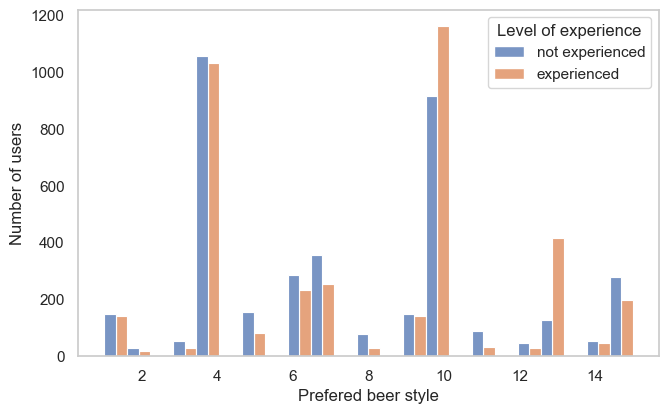

In [623]:
# Plot of histogram of prefered beer styles when the users have a little and lot of experience
a4_dims = (7.5, 4.5)
fig, ax = plt.subplots(figsize=a4_dims)
x = experienced_users_summary["fav_merged_style_before"].astype(int)
y = experienced_users_summary["fav_merged_style_after"].astype(int)

df_plot = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'beer_style': x, 'Level of experience': 'not experienced'}),
    pd.DataFrame.from_dict({'beer_style': y, 'Level of experience': 'experienced'})])
sns.histplot(data=df_plot, x="beer_style", hue="Level of experience",multiple="dodge")
ax.set_xlabel('Prefered beer style')
ax.set_ylabel('Number of users')
ax.grid(False)
plt.show()

This histogram shows that when users don't have much experience, their 3 prefered styles are the IPA's, the stouts, and the belgian styles in order of preference. However, when the users have a lot of experience, their 3 prefered styles are the stouts', the IPA's, and the scottish-style ales in order of preference.

We will now conduct the statistical test to see if this difference is significant.

In [319]:
# compute the 2 distributions
histogram_before = np.histogram(experienced_users_summary["fav_merged_style_before"].astype("int").values, bins=len(experienced_users_summary["fav_merged_style_before"].unique()))[0]
histogram_after = np.histogram(experienced_users_summary["fav_merged_style_after"].astype("int").values, bins=len(experienced_users_summary["fav_merged_style_after"].unique()))[0]

# Wilcoxon sign-rank test
stats.wilcoxon(histogram_before,histogram_after)

WilcoxonResult(statistic=29.0, pvalue=0.083251953125)

The p-value is between 0.05 and 0.1, thus we don't reject the null hypothesis at a confidence level of 5% but we can reject it at a confidence level of 10%.

## Find the supra-styles for each category and country of user

Now that we have our user categories, we want to determine which are the favorite styles of users depending on their country and level of experience. For example, we will compare the ratings for each style for different categories of German users. 

In [685]:
df_germany_experienced = df.loc[(df["user_country"]=="Germany") & (df["experienced"]==True)]
df_germany_novice = df.loc[(df["user_country"]=="Germany") & (df["novice"]==True)]

In [709]:
df_g1_mean = df_germany_experienced.groupby("style_merged")["rating"].mean()
df_g1_std = df_germany_experienced.groupby("style_merged")["rating"].std()
df_g2_mean = df_germany_novice.groupby("style_merged")["rating"].mean()
df_g2_std = df_germany_novice.groupby("style_merged")["rating"].std()
df_g2_mean[3] = 0.0
df_g2_std[3] = 0.0
df_g2_mean = df_g2_mean.sort_index()
df_g2_std = df_g2_std.sort_index()

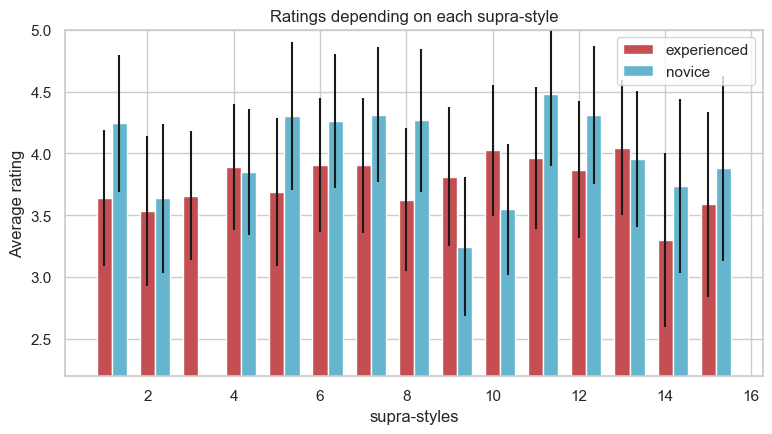

In [715]:
a4_dims = (9, 4.5)
fig, ax = plt.subplots(figsize=a4_dims)
bar_width = 0.35
width = 0.35
index = np.arange(1,16)
ax.bar(index, df_g1_mean.values, yerr=df_g1_std.values,label="experienced", width=width, color='r')
ax.bar(index+bar_width, df_g2_mean.values, yerr=df_g1_std.values,label="novice",width=width, color='c')
ax.set_xlabel('supra-styles')
ax.set_ylabel('Average rating')
ax.set_title("Ratings depending on each supra-style")
ax.legend()
plt.ylim([2.2,5])
plt.show()


From this plot we see that the 3 favorite beer styles of experienced German users are wild/sour beers (13), stouts (10), and while for novice German users the favorite beer styles are bocks (11), wheat beers (5) and Belgian-style ales (7). 

## Finding the best beers to place on the shelves

### First approach: Bayesian regression to even out the ratings

In this next part, we will compute a Bayesian linear regression to predict the rating of a beer based on its features. This prediction will be used to even out the ratings that are too far from the prediction. In fact, one beer might have been rated only once by a user who gave it a very high rating, but another user might have given it a lower rating, thus this beer should not necessarily be prefered over a beer with slightly lower average rating but with many ratings. We will use the confidence interval of our prediction to even out the ratings that are not within the interval. Finally, with the new ratings obtained we will pick out the 5 best rated beers for each style to recommend to a certain category of user.

In [448]:
# create column to categorize users based on their experience 
df["experienced"] = False
df["novice"] = False
df["experienced"] = df["user_nbr_ratings"].apply(lambda x: True if x>=40 else False)
df["novice"] = df["user_nbr_ratings"].apply(lambda x: True if x<=3 else False)
df["style_merged"] = df["style_merged"].astype('str') 

In [449]:
df.head()

,user_id,date,aroma,palate,taste,overall,rating,abv,style,country,beer_id,user_nbr_ratings,user_nbr_reviews,user_country,style_merged,experienced,novice
0,nmann08.184925,2015-08-20 10:00:00,2.75,3.25,2.75,3.00,2.88,4.5,Euro Pale Lager,Gabon,142544,7820,465,United States,14,True,False
1,nmann08.184925,2015-11-14 11:00:00,3.50,3.75,3.50,3.50,3.56,5.0,Extra Special / Strong Bitter (ESB),Wales,120824,7820,465,United States,1,True,False
2,nmann08.184925,2011-11-18 11:00:00,NaN,NaN,NaN,NaN,4.50,8.0,Old Ale,Scotland,47581,7820,465,United States,6,True,False
3,nmann08.184925,2013-05-03 10:00:00,NaN,NaN,NaN,NaN,3.75,10.5,Old Ale,Scotland,93113,7820,465,United States,6,True,False
4,nmann08.184925,2015-01-24 11:00:00,3.50,3.75,4.00,3.75,3.81,6.0,English Porter,Scotland,875,7820,465,United States,9,True,False


We will base our prediction of the ratings on the country were the beer was brewed, its abv and its suprastyle.

The prediction will be done for each user country and separately for experienced and non experienced users. In the following we will use the predictive model for experienced Belgian users. 

In [550]:
# separate dataframe into features and true prediction dataframes
df_new = df.loc[(df["user_country"]=="Belgium") & (df["experienced"]==True) & (df["style_merged"]=="7")][["abv","country","style_merged","rating","beer_id"]].reset_index(drop=True).dropna()
df_new["abv_normalized"] = (df_new["abv"]-df_new["abv"].mean())/df_new["abv"].std()
df_x = df_new["country"]
df_x = pd.get_dummies(df_x) 
df_y = df_new["rating"]

In [560]:
# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.3')
pyro.set_rng_seed(2)

# Define the data and model
x_data = torch.tensor(df_x.values,dtype=torch.float)
y_data = torch.tensor(df_y.values,dtype=torch.float)
#y_data = (y_data - y_data.mean())/y_data.std()

linear_reg_model = PyroModule[nn.Linear](25, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

In [561]:
# Define the Bayesian regression class
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [562]:
# Define regression model
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(25, 1)
guide = AutoDiagonalNormal(model)

We will use stochastic variational inference (SVI) for doing inference. Each iteration of our training loop will take a gradient step, we use the Evidence Lower Bound (ELBO) objective by constructing a Trace_ELBO object that we pass to SVI. We also use the Adam optimizer.

In [563]:
# Use adam optimizer and train model with svi
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [564]:
# Compute the loss
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))

[iteration 0001] loss: 2.8766
[iteration 0101] loss: 0.8626
[iteration 0201] loss: 0.8317
[iteration 0301] loss: 0.8243
[iteration 0401] loss: 0.8248
[iteration 0501] loss: 0.8238
[iteration 0601] loss: 0.8234
[iteration 0701] loss: 0.8245
[iteration 0801] loss: 0.8238
[iteration 0901] loss: 0.8225
[iteration 1001] loss: 0.8226
[iteration 1101] loss: 0.8228
[iteration 1201] loss: 0.8228
[iteration 1301] loss: 0.8244
[iteration 1401] loss: 0.8231


To evaluate the model, we generate some predictive samples and look at the posteriors. For this we will make use of the Predictive utility class. We generate 800 samples from our trained model to compute the confidence intervals and the mean prediction.

In [565]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

We generate the mean value of the response by calling the linear module. We also use the obs argument to the pyro.sample statement to condition on the observed data y_data with a learned observation noise sigma. The model returns the regression line (y_mean) and its confidence interval. We only keep the return value of the model which corresponds to the Bayesian regression line and its uncertainty.

In [593]:
mu = pred_summary["_RETURN"]
predictions = pd.DataFrame({
    "beer_id": df_new["beer_id"],
    "style": df_new["style_merged"],
    "country": df_new["country"],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "true_gdp": y_data,
    #"true_gdp": y_data*torch.tensor(df_y.values,dtype=torch.float).std()+torch.tensor(df_y.values,dtype=torch.float).mean()
})
predictions.head()

,beer_id,style,country,mu_mean,mu_perc_5,mu_perc_95,true_gdp
0,7728,7,Japan,3.255588,2.651922,3.837965,2.87
1,171890,7,Italy,3.941700,3.793548,4.092454,3.50
2,229841,7,Greece,3.655107,2.766169,4.535052,3.50
3,223652,7,Russia,3.597253,2.840086,4.337984,3.50
4,117899,7,Spain,3.468163,3.245060,3.690366,2.75


Now we will assign the regression value to the points that are not within the confidence interval of the prediction.

In [594]:
predictions['value'] = predictions['true_gdp']
number_of_outliers = len(predictions["value"].loc[(predictions["true_gdp"]>predictions["mu_perc_95"]) | (predictions["true_gdp"]<predictions["mu_perc_5"])])
predictions["value"].loc[(predictions["true_gdp"]>predictions["mu_perc_95"]) | (predictions["true_gdp"]<predictions["mu_perc_5"])] = predictions['mu_mean'].loc[(predictions["true_gdp"]>predictions["mu_perc_95"]) | (predictions["true_gdp"]<predictions["mu_perc_5"])]

/var/folders/h7/xbbqmmmx30v5l74r8b_tflw00000gn/T/ipykernel_73315/291611243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["value"].loc[(predictions["true_gdp"]>predictions["mu_perc_95"]) | (predictions["true_gdp"]<predictions["mu_perc_5"])] = predictions['mu_mean'].loc[(predictions["true_gdp"]>predictions["mu_perc_95"]) | (predictions["true_gdp"]<predictions["mu_perc_5"])]


Now we will predict the top-10 beers from the Belgian-style ales for Belgian experienced users.

In [595]:
predictions = predictions.merge(df_beers[["beer_id","beer_name"]],right_on="beer_id",left_on="beer_id")
beers = pd.DataFrame(columns=["beer_name","country","approx_rating"]) 
for key,group in predictions.groupby("beer_id"):
    beer = {
        "beer_name": [group["beer_name"].iloc[0]],
        "country": [group["country"].iloc[0]],
        "approx_rating":[group["value"].mean()]
    }
    beers = pd.concat([beers, pd.DataFrame(beer)], axis=0)
beers.reset_index(drop=True, inplace=True)
beers.sort_values(by="approx_rating",ascending=False).head(10)

,beer_name,country,approx_rating
1169,Black Jacques,Scotland,4.34
1261,Hoppy Monk,Singapore,4.29
1082,Lambda,Canada,4.28
860,Unibroue 17 Grande Réserve,Canada,4.28
2,Eau Benite,Canada,4.111635
482,Noire De Chambly / Chambly Noire,Canada,4.111635
1213,Albert 3,Canada,4.111635
788,Dulcis Succubus,Canada,4.111635
286,L'Évêque,Canada,4.111635
28,Raftman,Canada,4.111635


These are the top 10 beers to recommend to Belgian experienced users in the Belgian-Style ales which is their favorite style

### 2nd approach: set threshold to minimal number of ratings for a beer

As a second approach, we would like to set a threshold to the minimum number of beers such that we take into account the rating of this beer to find the best beers for each style. As we saw before, the distribution of number of beers is very heavy tailed. The median is at 3 ratings for each beer and the 3rd quantile is at 9 beers. We choose a threshold of a minimal number of 3 ratings for each beer.

For German users, it was found that the favorite style for experienced users is wild/sour beers and for novice users it is bocks. Thus, we will determine 10 beers for each  category to place on the shelves. 

In [731]:
# get beer id's that have more than 3 ratings
used_beer_ids_1 = df_germany_experienced.groupby('beer_id')['beer_id'].agg(['count']).loc[df_germany_experienced.groupby('beer_id')['beer_id'].agg(['count'])["count"]>3].reset_index()["beer_id"].values
used_beer_ids_2 = df_germany_novice.groupby('beer_id')['beer_id'].agg(['count']).loc[df_germany_novice.groupby('beer_id')['beer_id'].agg(['count'])["count"]>3].reset_index()["beer_id"].values

In [736]:
# get average rating for each beer and sort 
mean_ratings_1 = df_germany_experienced.groupby('beer_id')['rating'].agg(['mean']).reset_index().sort_values(by="mean",ascending=False)



,beer_id,mean
2215,22000,5.0
7886,235041,5.0
5017,72369,5.0
1851,15578,5.0
77,167,5.0
1395,7660,5.0
4922,70330,5.0
1890,16082,5.0
5332,77601,5.0
5399,78820,5.0


In [ ]:
df_grouped_by_beer = df_germany_experienced["beer_id","rating",""]